In [1]:
!pip install pyod

# Evaluation des Gesamtsystems

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from pyod.models.lof import LOF

import pyod_experiments as exp

%matplotlib inline

## Laden der Datensätze

In [3]:
owa1 = pd.read_csv("../data/owa_dataset.csv")
owa2 = pd.read_csv("../data/owa2_dataset.csv")
owa3 = pd.read_csv("../data/owa3_dataset.csv")

owa1["visit_date"] = pd.to_datetime(owa1["visit_date"])
owa1 = owa1.set_index("visit_date")
owa2["visit_date"] = pd.to_datetime(owa2["visit_date"])
owa2 = owa2.set_index("visit_date")
owa3["visit_date"] = pd.to_datetime(owa3["visit_date"])
owa3 = owa3.set_index("visit_date")

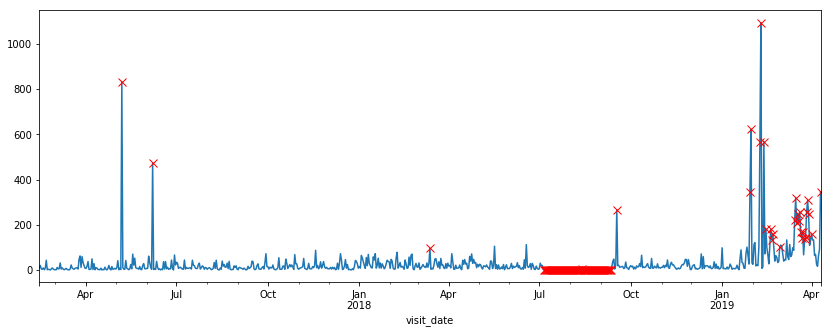

In [4]:
owa2["hits"].plot(figsize=(14,5), marker="x", markevery=(owa2["anomalyClass"] == 1).tolist(), ms=8, markeredgecolor="red")
plt.margins(x=0)
plt.show()

## Ergebnisse auf den produktiven Datensätzen

In [5]:
resOWA = exp.runSingleConfiguration(owa1.copy(deep=True).astype(float), ["hits"], owa1["anomalyClass"].tolist(), LOF, { "n_neighbors": 75 })
resOWA2 = exp.runSingleConfiguration(owa2.copy(deep=True).astype(float), ["hits"], owa2["anomalyClass"].tolist(), LOF, { "n_neighbors": 75 })
resOWA3 = exp.runSingleConfiguration(owa3.copy(deep=True).astype(float), ["hits"], owa3["anomalyClass"].tolist(), LOF, { "n_neighbors": 75 })
ap = [resOWA["avg_precision"], resOWA2["avg_precision"], resOWA3["avg_precision"]]
auc = [resOWA["auc"], resOWA2["auc"], resOWA3["auc"]]

pd.DataFrame( {"Average Precision": ap, "AUC Score": auc}, index=["OWA", "OWA-2", "OWA-3"] )

,Average Precision,AUC Score
OWA,0.868542,0.922189
OWA-2,0.393551,0.498489
OWA-3,0.300275,0.366719


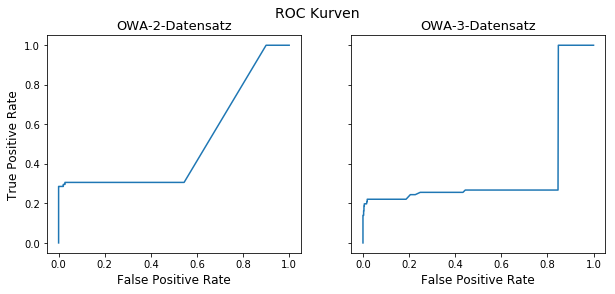

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.suptitle("ROC Kurven", fontsize=14)
fig.set_size_inches(10, 4)

fpr, tpr, thresholds = roc_curve(owa2["anomalyClass"], resOWA2["scores"])
ax1.plot(fpr, tpr)
ax1.set_title("OWA-2-Datensatz", fontsize=13)
ax1.set_ylabel("True Positive Rate", fontsize=12)
ax1.set_xlabel("False Positive Rate", fontsize=12)

fpr, tpr, thresholds = roc_curve(owa3["anomalyClass"], resOWA3["scores"])
ax2.plot(fpr, tpr)
ax2.set_title("OWA-3-Datensatz", fontsize=13)
ax2.set_xlabel("False Positive Rate", fontsize=12)
plt.show()

### Analyse der falsch klassifizierten Datenpunkte

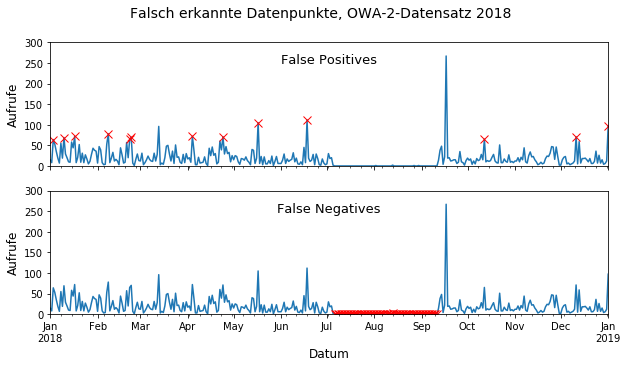

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Falsch erkannte Datenpunkte, OWA-2-Datensatz 2018", fontsize=14)

axFP = owa2["hits"].plot(figsize=(10,5), marker="x", markevery=((resOWA2["labels"] == 1) & (owa2["anomalyClass"] == 0)).tolist(), ms=8, markeredgecolor="red", ax=axes[0], sharex=True)
axFP.set_xlabel("Datum", fontsize=12)
axFP.set_ylabel("Aufrufe", fontsize=12)
axFP.set_title("False Positives", fontsize=13, y=0.78)
axFP.set_ylim(0, 300)
axFP.set_xlim("2018-01-01", "2019-01-01")

axFN = owa2["hits"].plot(figsize=(10,5), marker="x", markevery=((resOWA2["labels"] == 0) & (owa2["anomalyClass"] == 1)).tolist(), ms=8, markeredgecolor="red", ax=axes[1])
axFN.set_xlabel("Datum", fontsize=12)
axFN.set_ylabel("Aufrufe", fontsize=12)
axFN.set_title("False Negatives", fontsize=13, y=0.78)
axFN.set_ylim(0, 300)
axFN.set_xlim("2018-01-01", "2019-01-01")
plt.show()

**Auswirkungen von Ausfällen unterschiedlicher Länge auf die Genauigkeit von LOF**

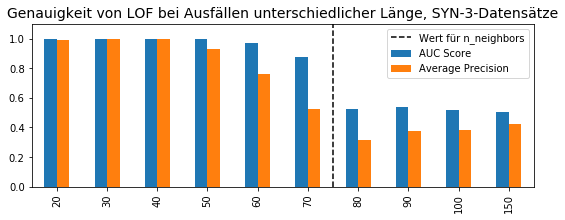

In [8]:
testFiles = ["20", "30", "40", "50", "60", "70", "80", "90", "100", "150"]
resultDict = { "AUC Score": [], "Average Precision": [] }
resultDict2 = { "AUC Score": [], "Average Precision": [] }

for testFile in testFiles:
  syn3 = pd.read_csv("../data/syn_datasets/syn3_dataset_" + testFile + ".csv")

  res = exp.runSingleConfiguration(syn3, ["hits"], syn3["anomalyClass"].tolist(), LOF, { "n_neighbors": 75 })
  resultDict["AUC Score"].append(res["auc"])
  resultDict["Average Precision"].append(res["avg_precision"])

resDf = pd.DataFrame(resultDict, index=testFiles)
ax = resDf.plot.bar(figsize=(9,3))
ax.set_title("Genauigkeit von LOF bei Ausfällen unterschiedlicher Länge, SYN-3-Datensätze", fontsize=14)
ax.vlines(5.5, 0, 1.2, linestyles="dashed", label="Wert für n_neighbors")
ax.set_ylim(0, 1.1)
plt.legend()
plt.show()

## Ergebnisse nach Behandlung von Ausfällen

In [9]:
owa2.loc[500:600, "anomalyClass"] = 0
owa3.loc[500:600, "anomalyClass"] = 0

In [10]:
resOWA = exp.runSingleConfiguration(owa1.copy(deep=True).astype(float), ["hits"], owa1["anomalyClass"].tolist(), LOF, { "n_neighbors": 75 })
resOWA2 = exp.runSingleConfiguration(owa2.copy(deep=True).astype(float), ["hits"], owa2["anomalyClass"].tolist(), LOF, { "n_neighbors": 75 })
resOWA3 = exp.runSingleConfiguration(owa3.copy(deep=True).astype(float), ["hits"], owa3["anomalyClass"].tolist(), LOF, { "n_neighbors": 75 })
ap = [resOWA["avg_precision"], resOWA2["avg_precision"], resOWA3["avg_precision"]]
auc = [resOWA["auc"], resOWA2["auc"], resOWA3["auc"]]

pd.DataFrame( {"Average Precision": ap, "AUC Score": auc}, index=["OWA", "OWA-2", "OWA-3"] )

,Average Precision,AUC Score
OWA,0.868542,0.922189
OWA-2,0.942611,0.997634
OWA-3,0.916862,0.997362


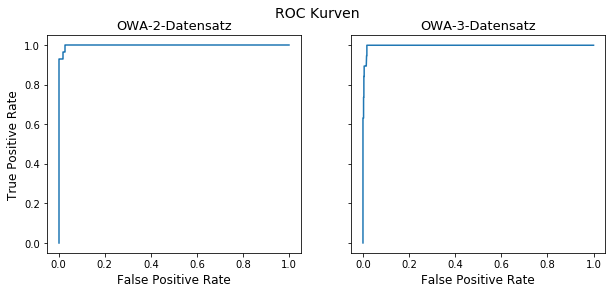

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.suptitle("ROC Kurven", fontsize=14)
fig.set_size_inches(10, 4)

fpr, tpr, thresholds = roc_curve(owa2["anomalyClass"], resOWA2["scores"])
ax1.plot(fpr, tpr)
ax1.set_title("OWA-2-Datensatz", fontsize=13)
ax1.set_ylabel("True Positive Rate", fontsize=12)
ax1.set_xlabel("False Positive Rate", fontsize=12)

fpr, tpr, thresholds = roc_curve(owa3["anomalyClass"], resOWA3["scores"])
ax2.plot(fpr, tpr)
ax2.set_title("OWA-3-Datensatz", fontsize=13)
ax2.set_xlabel("False Positive Rate", fontsize=12)
plt.show()